### Inference
- __[Feature Engineer](https://towardsdatascience.com/feature-engineering-feature-selection-8c1d57af18d2)__ - Ke Gui
- __[Data Label](https://towardsdatascience.com/feature-engineering-feature-selection-8c1d57af18d2)__  - Ke Gui
- __[Random Forest](https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76)__  - Will Koehrsen
- __[機器學習全流程](https://daniel820710.medium.com/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92%E5%BE%9E%E9%9B%B6%E5%88%B0%E4%B8%80-day2-%E5%BB%BA%E7%AB%8B%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92%E7%92%B0%E5%A2%83-gpu-environment-410c22966769)__  - PJ Wang

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
# plt.rcParams['figure.figsize'] = [16, 9]
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['font.size'] = 20
# plt.rcParams['axes.labelsize'] = 20
# plt.rcParams['axes.titlesize'] = 24
# plt.rcParams['xtick.labelsize'] = 16
# plt.rcParams['ytick.labelsize'] = 16
# plt.rcParams['font.family'] = 'serif'

pd.set_option('display.max_columns', None)

In [63]:
from finlab.data import Data
database = Data()

close = database.get("收盤價")
open_ = database.get("開盤價")
high = database.get("最高價")
low = database.get("最低價")
vol = database.get("成交股數")
rev = database.get("當月營收")
com_rev = database.get("上月比較增減(%)")
d_yield = database.get("殖利率(%)")
pb = database.get("股價淨值比")

sid = '2330'

data = pd.DataFrame({'close': close[sid],
                   'open': open_[sid],
                   'high': high[sid],
                   'low': low[sid]})

data.tail()
print(f'shape of df {data.shape}')

shape of df (3621, 4)


In [64]:
# Apple_stock = pd.read_csv('AAPL.csv') 
# Apple_stock = Apple_stock.set_index('Date')
price = data['close']

In [65]:
def get_Daily_Volatility(close,span0=20):
    # simple percentage returns
    df0=close.pct_change()
    # 20 days, a month EWM's std as boundary
    df0=df0.ewm(span=span0).std()
    df0.dropna(inplace=True)
    return df0

In [66]:
df0 = get_Daily_Volatility(price)

In [67]:
def get_atr(stock, win=14):
    
    atr_df = pd.Series(index=stock.index)
    high = pd.Series(data.high.rolling( \
                     win, min_periods=win))
    low = pd.Series(data.low.rolling( \
                    win, min_periods=win))
    close = pd.Series(data.close.rolling( \
                      win, min_periods=win))    
          
    for i in range(len(stock.index)):
        tr=np.max([(high[i] - low[i]), \
                  np.abs(high[i] - close[i]), \
                  np.abs(low[i] - close[i])], \
                  axis=0)
    atr_df[i] = tr.sum() / win
     
    return  atr_df

In [68]:
#set the boundary of barriers, based on 20 days EWM
daily_volatility = get_Daily_Volatility(price)
# how many days we hold the stock which set the vertical barrier
t_final = 10 
#the up and low boundary multipliers
upper_lower_multipliers = [2, 2]

In [69]:
#allign the index
prices = price[daily_volatility.index]

def get_3_barriers():
    #create a container
    barriers = pd.DataFrame(columns=['days_passed', 
              'price', 'vert_barrier', \
              'top_barrier', 'bottom_barrier'], \
               index = daily_volatility.index)
    for day, vol in daily_volatility.iteritems():
        days_passed = len(daily_volatility.loc \
                      [daily_volatility.index[0] : day])
        #set the vertical barrier 
        if (days_passed + t_final < len(daily_volatility.index) \
            and t_final != 0):
            vert_barrier = daily_volatility.index[
                                days_passed + t_final]
        else:
            vert_barrier = np.nan
        #set the top barrier
        if upper_lower_multipliers[0] > 0:
            top_barrier = prices.loc[day] + prices.loc[day] * \
                          upper_lower_multipliers[0] * vol
        else:
            #set it to NaNs
            top_barrier = pd.Series(index=prices.index)
        #set the bottom barrier
        if upper_lower_multipliers[1] > 0:
            bottom_barrier = prices.loc[day] - prices.loc[day] * \
                          upper_lower_multipliers[1] * vol
        else: 
            #set it to NaNs
            bottom_barrier = pd.Series(index=prices.index)

        barriers.loc[day, ['days_passed', 'price', 'vert_barrier','top_barrier', 'bottom_barrier']] = \
         days_passed, prices.loc[day], vert_barrier, \
         top_barrier, bottom_barrier
    return barriers

In [70]:
barriers = get_3_barriers()
barriers

,days_passed,price,vert_barrier,top_barrier,bottom_barrier
date,,,,,
2007-04-25,1,69.3,2007-05-11 00:00:00,71.7164,66.8836
2007-04-26,2,69.9,2007-05-14 00:00:00,71.6138,68.1862
2007-04-27,3,69,2007-05-15 00:00:00,70.9204,67.0796
2007-04-30,4,68.7,2007-05-16 00:00:00,70.3452,67.0548
2007-05-02,5,68,2007-05-17 00:00:00,69.5336,66.4664
...,...,...,...,...,...
2021-12-13,3615,601,NaN,613.656,588.344
2021-12-14,3616,599,NaN,611.043,586.957
2021-12-15,3617,600,NaN,611.507,588.493


In [71]:
barriers.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3619 entries, 2007-04-25 to 2021-12-17
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   days_passed     3619 non-null   object
 1   price           3619 non-null   object
 2   vert_barrier    3608 non-null   object
 3   top_barrier     3619 non-null   object
 4   bottom_barrier  3619 non-null   object
dtypes: object(5)
memory usage: 329.6+ KB


In [72]:
barriers['out'] = None
barriers.head()

,days_passed,price,vert_barrier,top_barrier,bottom_barrier,out
date,,,,,,
2007-04-25,1,69.3,2007-05-11 00:00:00,71.7164,66.8836,None
2007-04-26,2,69.9,2007-05-14 00:00:00,71.6138,68.1862,None
2007-04-27,3,69,2007-05-15 00:00:00,70.9204,67.0796,None
2007-04-30,4,68.7,2007-05-16 00:00:00,70.3452,67.0548,None
2007-05-02,5,68,2007-05-17 00:00:00,69.5336,66.4664,None


In [73]:
def get_labels():
    for i in range(len(barriers.index)):
        start = barriers.index[i]
        end = barriers.vert_barrier[i]
        if pd.notna(end):
            # assign the initial and final price
            price_initial = barriers.price[start]
            price_final = barriers.price[end]
            # assign the top and bottom barriers
            top_barrier = barriers.top_barrier[i]
            bottom_barrier = barriers.bottom_barrier[i]
            #set the profit taking and stop loss conditons
            condition_pt = (barriers.price[start: end] >= \
             top_barrier).any()
            condition_sl = (barriers.price[start: end] <= \
             bottom_barrier).any()
            #assign the labels 如果True情況下不設out為2會產生touch vertical bar 時產生 > 1 的值
            if condition_pt: 
                barriers['out'][i] = 1
            elif condition_sl: 
                barriers['out'][i] = -1    
            else: 
                barriers['out'][i] = 0
                # barriers['out'][i] = max(
                #           [(price_final - price_initial)/ 
                #            (top_barrier - price_initial), \
                #            (price_final - price_initial)/ \
                #            (price_initial - bottom_barrier)],\
                #             key=abs)
    return

In [74]:
get_labels()
barriers

,days_passed,price,vert_barrier,top_barrier,bottom_barrier,out
date,,,,,,
2007-04-25,1,69.3,2007-05-11 00:00:00,71.7164,66.8836,0
2007-04-26,2,69.9,2007-05-14 00:00:00,71.6138,68.1862,-1
2007-04-27,3,69,2007-05-15 00:00:00,70.9204,67.0796,-1
2007-04-30,4,68.7,2007-05-16 00:00:00,70.3452,67.0548,-1
2007-05-02,5,68,2007-05-17 00:00:00,69.5336,66.4664,0
...,...,...,...,...,...,...
2021-12-13,3615,601,NaN,613.656,588.344,None
2021-12-14,3616,599,NaN,611.043,586.957,None
2021-12-15,3617,600,NaN,611.507,588.493,None


In [75]:
# fig,ax = plt.subplots()
# ax.set(title='Apple stock price',
#        xlabel='date', ylabel='price')
# ax.plot(barriers.price[100: 200])
# start = barriers.index[120]
# end = barriers.vert_barrier[120]
# upper_barrier = barriers.top_barrier[120]
# lower_barrier = barriers.bottom_barrier[120]
# ax.plot([start, end], [upper_barrier, upper_barrier], 'r--');
# ax.plot([start, end], [lower_barrier, lower_barrier], 'r--');
# ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, \
#                        (lower_barrier + upper_barrier)*0.5], 'r--');
# ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
# ax.plot([end, end], [lower_barrier, upper_barrier], 'r-');
# #dynamic graph
# fig,ax = plt.subplots()
# ax.set(title='Apple stock price',
#        xlabel='date', ylabel='price')
# ax.plot(barriers.price[100: 200])
# start = barriers.index[120]
# end = barriers.index[120+t_final]
# upper_barrier = barriers.top_barrier[120]
# lower_barrier = barriers.bottom_barrier[120]
# ax.plot(barriers.index[120:120+t_final+1], barriers.top_barrier[start:end], 'r--');
# ax.plot(barriers.index[120:120+t_final+1], barriers.bottom_barrier[start:end], 'r--');
# ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, \
#                        (lower_barrier + upper_barrier)*0.5], 'r--');
# ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
# ax.plot([end, end], [barriers.bottom_barrier[end], barriers.top_barrier[end]], 'r-');

In [76]:
# plt.plot(barriers.out,'bo')

In [77]:
barriers.out.value_counts()

 1    1707
-1    1080
 0     821
Name: out, dtype: int64

In [78]:
barriers.head()

,days_passed,price,vert_barrier,top_barrier,bottom_barrier,out
date,,,,,,
2007-04-25,1,69.3,2007-05-11 00:00:00,71.7164,66.8836,0
2007-04-26,2,69.9,2007-05-14 00:00:00,71.6138,68.1862,-1
2007-04-27,3,69,2007-05-15 00:00:00,70.9204,67.0796,-1
2007-04-30,4,68.7,2007-05-16 00:00:00,70.3452,67.0548,-1
2007-05-02,5,68,2007-05-17 00:00:00,69.5336,66.4664,0


In [79]:
data = data.reset_index()
data.dropna(axis=0, how='any', inplace=True)
rev = rev.reset_index()
print(f'shape of df {data.shape}')
data = pd.merge(data,rev[['date',sid]], on="date", how='outer')
print(f'shape of df {data.shape}')
data = data.sort_values(by=['date'])
data = data.rename(columns={sid: "rev"})
data['rev'].fillna(method='ffill', inplace=True)

com_rev = com_rev.reset_index()
print(f'shape of df {data.shape}')
data = pd.merge(data,com_rev[['date',sid]], on="date", how='outer')
print(f'shape of df {data.shape}')
data = data.sort_values(by=['date'])
data = data.rename(columns={sid: "com_rev"})
data['com_rev'].fillna(method='ffill', inplace=True)

d_yield = d_yield.reset_index()
print(f'shape of df {data.shape}')
data = pd.merge(data,d_yield[['date',sid]], on="date", how='outer')
print(f'shape of df {data.shape}')
data = data.rename(columns={sid: "d_yield"})
data['d_yield'].fillna(method='ffill', inplace=True)

pb = pb.reset_index()
print(f'shape of df {data.shape}')
data = pd.merge(data,pb[['date',sid]], on="date", how='outer')
print(f'shape of df {data.shape}')
data = data.rename(columns={sid: "pb"})
data['pb'].fillna(method='ffill', inplace=True)

data = data.set_index('date')
print(f'shape of df {data.shape}')
data.dropna(axis=0, how='any', inplace=True)
print(f'shape of df {data.shape}')
data.head()

shape of df (3621, 5)
shape of df (3710, 6)
shape of df (3710, 6)
shape of df (3710, 7)
shape of df (3710, 7)
shape of df (3710, 8)
shape of df (3710, 8)
shape of df (3710, 9)
shape of df (3710, 8)
shape of df (2945, 8)


,close,open,high,low,rev,com_rev,d_yield,pb
date,,,,,,,,
2010-01-04,64.9,65.0,65.0,64.0,29349036.0,0.57,4.65,3.63
2010-01-05,64.5,65.0,65.1,63.9,29349036.0,0.57,4.68,3.61
2010-01-06,64.9,64.5,64.9,63.7,29349036.0,0.57,4.65,3.63
2010-01-07,64.2,64.9,65.0,64.2,29349036.0,0.57,4.70,3.59
2010-01-08,64.0,63.5,64.3,63.5,29349036.0,0.57,4.72,3.58


In [80]:
data.tail()

,close,open,high,low,rev,com_rev,d_yield,pb
date,,,,,,,,
2021-12-13,601.0,609.0,610.0,601.0,148267599.0,10.2,1.66,7.51
2021-12-14,599.0,598.0,600.0,597.0,148267599.0,10.2,1.67,7.48
2021-12-15,600.0,597.0,601.0,596.0,148267599.0,10.2,1.67,7.49
2021-12-16,605.0,605.0,605.0,601.0,148267599.0,10.2,1.65,7.56
2021-12-17,607.0,601.0,607.0,599.0,148267599.0,10.2,1.65,7.58


In [81]:
# Technique indicator
# Compute RSI
def relative_strength_index(df, n):
        """Calculate Relative Strength Index(RSI) for given data.
        https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py
        
        :param df: pandas.DataFrame
        :param n: 
        :return: pandas.DataFrame
        """
        i = 0
        UpI = [0]
        DoI = [0]
        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0
            UpI.append(UpD)
            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0
            DoI.append(DoD)
            i = i + 1
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
        RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
        # df = df.join(RSI)
        return RSI

def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

def bbands(close_prices, window, no_of_stdev):
    # rolling_mean = close_prices.rolling(window=window).mean()
    # rolling_std = close_prices.rolling(window=window).std()
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

def MA(close, n):
    return close.rolling(window=n).mean()

def bias(close, n):
    return close / close.rolling(n, min_periods=1).mean()

def acc(close, n):
    return close.shift(n) / (close.shift(2*n) + close) * 2

def mom(rev, n):
    return (rev / rev.shift(1)).shift(n)

# def return_MA(rev, n):
#     return rev.rolling(window=n).mean()

In [82]:
data['MA5'] = MA(data['close'], 5)
data['MA60'] = MA(data['close'], 60)

data['bias5'] = bias(data['close'], 5)
data['bias10'] = bias(data['close'], 10)
data['bias20'] = bias(data['close'], 20)
data['bias60'] = bias(data['close'], 60)
# data['bias120'] = bias(data['close'], 120)
# data['bias240'] = bias(data['close'], 240)

data['acc5'] = acc(data['close'], 5)
data['acc10'] = acc(data['close'], 10)
data['acc20'] = acc(data['close'], 20)
data['acc60'] = acc(data['close'], 60)
# data['acc120'] = acc(data['close'], 120)
# data['acc240'] = acc(data['close'], 240)

# 用處不大，需在rev merge前就計算完成
# data['mom5'] = mom(data['rev'], 5)
# data['mom10'] = mom(data['rev'], 10)
# data['mom20'] = mom(data['rev'], 20)
# data['mom60'] = mom(data['rev'], 60)
# data['mom120'] = mom(data['rev'], 120)
# data['mom240'] = mom(data['rev'], 240)

In [83]:
data.describe()

,close,open,high,low,rev,com_rev,d_yield,pb,MA5,MA60,bias5,bias10,bias20,bias60,acc5,acc10,acc20,acc60
count,2945.000000,2945.000000,2945.000000,2945.000000,2.945000e+03,2945.000000,2945.000000,2945.000000,2941.000000,2886.000000,2945.000000,2945.000000,2945.000000,2945.000000,2935.000000,2925.000000,2905.000000,2825.000000
mean,200.994092,201.033582,202.445806,199.364720,7.136892e+07,1.644570,3.216842,4.137192,200.812574,198.326486,1.001555,1.003519,1.007472,1.023523,1.000015,0.999949,0.999753,0.999764
std,149.064372,149.214848,150.203272,147.865488,2.980617e+07,13.856902,0.832688,1.400351,148.710944,143.764793,0.015596,0.022925,0.032850,0.056966,0.022620,0.030685,0.042107,0.075552
min,57.200000,57.600000,57.900000,57.000000,2.915627e+07,-33.770000,1.410000,2.700000,57.920000,60.410000,0.923650,0.865318,0.817807,0.768079,0.864111,0.828739,0.786677,0.758410
25%,96.300000,96.000000,96.900000,95.300000,4.413422e+07,-6.770000,2.740000,3.320000,96.400000,99.773333,0.992319,0.990099,0.987550,0.987019,0.985602,0.979852,0.973466,0.953642
50%,146.500000,146.000000,147.500000,145.500000,7.043830e+07,0.520000,3.230000,3.650000,146.300000,145.983333,1.001405,1.003547,1.008282,1.022981,1.000000,1.000000,1.000000,0.997279
75%,243.000000,243.000000,244.500000,241.000000,9.191717e+07,7.990000,3.680000,4.160000,242.900000,243.050000,1.011327,1.017237,1.027129,1.057567,1.014345,1.019640,1.026166,1.046358
max,673.000000,664.000000,679.000000,660.000000,1.526854e+08,60.420000,5.280000,9.760000,653.200000,613.350000,1.083461,1.130604,1.200745,1.346020,1.128248,1.129195,1.203936,1.326923


In [84]:
# compute bands
window = 20
data['avg'], data['upper'], data['lower'] = bbands(data['close'], window, no_of_stdev=1.5)
# data.sample(10)

In [85]:
# Compute RSI
rsi_df = get_rsi(data, window=14)
data['rsi'] = pd.Series(data=rsi_df.values, index=data.index)

# Drop the NaN values from our data set
# print(f'ori shape : {data.shape}')
# data.dropna(axis=0, how='any', inplace=True)
# print(f'aft shape : {data.shape}')

In [86]:
# Compute sides
data['side'] = np.nan 
data['cs1'] = data['close'].shift(1)
data['ma60s3'] = data['MA60'].shift(3)
long_signals = (data['close'] >= data['MA5']) & (data['cs1'] <= data['MA5']) & (data['ma60s3'] <= data['MA60'])
short_signals = (data['close'] <= data['MA5']) & (data['cs1'] >= data['MA5']) & (data['ma60s3'] >= data['MA60']) 

data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1
# data['side'].fillna(value=0, inplace=True)
print(data.side.value_counts())

# Remove Look ahead biase by lagging the signal
data['side'] = data['side'].shift(1)

 1.0    345
-1.0    123
Name: side, dtype: int64


In [87]:
data = data.reset_index()
barriers = barriers.reset_index()
data = pd.merge(data,barriers[['date','out']], on="date")

In [88]:
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [89]:
data[data.out.isnull()][['side', 'out']]

,side,out
2934,NaN,None
2935,NaN,None
2936,-1.0,None
2937,NaN,None
2938,-1.0,None
2939,NaN,None
2940,NaN,None
2941,-1.0,None
2942,NaN,None
2943,NaN,None


In [90]:
primary_forecast = data[(~data.side.isnull()) & (~data.out.isnull())][['side', 'out']]
primary_forecast = primary_forecast.astype(int)
primary_forecast.columns = ['pred', 'actual']
primary_forecast.head()

,pred,actual
65,-1,-1
87,1,-1
95,-1,1
97,-1,1
104,-1,1


In [91]:
primary_forecast.pred.unique()

array([-1,  1])

In [92]:
# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

C:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

          -1       0.23      0.21      0.22       131
           0       0.00      0.00      0.00       118
           1       0.44      0.70      0.54       215

    accuracy                           0.39       464
   macro avg       0.22      0.31      0.25       464
weighted avg       0.27      0.39      0.31       464

Confusion Matrix
[[ 28   0 103]
 [ 28   0  90]
 [ 64   0 151]]

Accuracy
0.3857758620689655


In [93]:
# Save the raw data
raw_data = data.copy()
raw_data.head()

,date,close,open,high,low,rev,com_rev,d_yield,pb,MA5,MA60,bias5,bias10,bias20,bias60,acc5,acc10,acc20,acc60,avg,upper,lower,rsi,side,cs1,ma60s3,out
0,2010-01-04,64.9,65.0,65.0,64.0,29349036.0,0.57,4.65,3.63,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,64.900000,NaN,NaN,NaN,NaN,NaN,NaN,-1
1,2010-01-05,64.5,65.0,65.1,63.9,29349036.0,0.57,4.68,3.61,NaN,NaN,0.996909,0.996909,0.996909,0.996909,NaN,NaN,NaN,NaN,64.690000,65.114264,64.265736,NaN,NaN,64.9,NaN,-1
2,2010-01-06,64.9,64.5,64.9,63.7,29349036.0,0.57,4.65,3.63,NaN,NaN,1.002059,1.002059,1.002059,1.002059,NaN,NaN,NaN,NaN,64.767111,65.113809,64.420412,NaN,NaN,64.5,NaN,-1
3,2010-01-07,64.2,64.9,65.0,64.2,29349036.0,0.57,4.70,3.59,NaN,NaN,0.993424,0.993424,0.993424,0.993424,NaN,NaN,NaN,NaN,64.603395,65.127815,64.078974,NaN,NaN,64.9,NaN,-1
4,2010-01-08,64.0,63.5,64.3,63.5,29349036.0,0.57,4.72,3.58,64.5,NaN,0.992248,0.992248,0.992248,0.992248,NaN,NaN,NaN,NaN,64.457439,65.077393,63.837484,NaN,NaN,64.2,NaN,-1


In [94]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
window_stdev = 50
raw_data['volatility'] = raw_data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# Add fast and slow moving averages
fast_window = 7
slow_window = 15

raw_data['fast_mavg'] = raw_data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
raw_data['slow_mavg'] = raw_data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()


In [95]:
# Add Trending signals
raw_data['sma'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']
raw_data.loc[long_signals, 'sma'] = 1
raw_data.loc[short_signals, 'sma'] = -1

In [96]:
# Remove look ahead bias
raw_data = raw_data.shift(1)

In [97]:
raw_data.dropna(axis=0, how='any', inplace=True)
raw_data.tail()

,date,close,open,high,low,rev,com_rev,d_yield,pb,MA5,MA60,bias5,bias10,bias20,bias60,acc5,acc10,acc20,acc60,avg,upper,lower,rsi,side,cs1,ma60s3,out,log_ret,mom1,mom2,mom3,mom4,mom5,volatility,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5,fast_mavg,slow_mavg,sma
2899,2021-10-14,573.0,579.0,579.0,573.0,152685418.0,11.1,1.75,7.46,574.8,590.300000,0.996868,0.997736,0.978567,0.970693,0.990460,0.976431,1.063094,1.000000,583.263846,606.724768,559.802923,41.0,-1.0,571.0,591.400000,1,0.003497,0.003503,-0.003478,-0.003478,-0.012069,0.003503,0.011811,0.261276,-0.011101,0.005260,0.064778,0.091364,-0.006981,0.000000,-0.008658,0.015639,-0.001750,573.857143,580.333333,-1.0
2906,2021-10-25,593.0,597.0,597.0,590.0,152685418.0,11.1,1.69,7.72,597.4,591.900000,0.992635,1.005767,1.014022,1.001858,1.010274,0.965575,1.015280,0.978041,589.996934,609.840570,570.153297,57.0,1.0,600.0,591.066667,0,-0.011735,-0.011667,-0.005034,-0.008361,-0.011667,0.005085,0.013939,0.086161,0.029328,0.032082,-0.059379,0.207193,0.006689,-0.003350,-0.003339,0.016807,-0.016807,596.714286,584.400000,1.0
2908,2021-10-27,599.0,598.0,599.0,594.0,152685418.0,11.1,1.67,7.80,597.4,592.483333,1.002678,1.007061,1.024107,1.010999,1.022222,0.957251,0.991653,0.978078,591.630143,610.361007,572.899279,62.0,1.0,599.0,591.666667,0,0.000000,0.000000,0.010118,-0.001667,0.005034,0.001672,0.013912,0.070515,0.032841,0.011386,-0.103292,0.196475,0.010067,-0.011735,0.006689,-0.003350,-0.003339,597.857143,588.000000,1.0
2915,2021-11-05,600.0,598.0,600.0,595.0,152685418.0,11.1,1.67,7.81,592.2,592.366667,1.013171,1.010611,1.015658,1.012886,0.983333,1.016949,0.948487,1.028721,592.061113,606.063903,578.058324,55.0,-1.0,587.0,592.333333,1,0.021905,0.022147,0.013514,0.013514,0.016949,0.016949,0.013058,-0.036658,0.000424,0.075302,0.009714,0.257344,-0.008482,0.000000,0.003384,0.000000,-0.008439,592.285714,594.733333,-1.0
2916,2021-11-08,602.0,600.0,602.0,598.0,152685418.0,11.1,1.66,7.84,594.6,592.566667,1.012445,1.012445,1.016720,1.015919,0.987448,1.007647,0.941851,1.005111,593.007674,607.063402,578.951946,58.0,1.0,600.0,592.350000,1,0.003328,0.003333,0.025554,0.016892,0.016892,0.020339,0.012690,-0.071138,-0.027497,0.048354,-0.033754,0.268798,0.021905,-0.008482,0.000000,0.003384,0.000000,593.285714,595.533333,-1.0


In [98]:
raw_data.shape

(458, 47)

In [99]:
raw_data['bin'] = raw_data['out'].apply(lambda x: 0 if x == -1 else (0 if x == 0 else 1))
y = raw_data['bin']

In [100]:
# Get features at event dates
X = raw_data.copy()

# Drop unwanted columns
X.drop(['bin', 'date','avg', 'upper', 'lower', 'open', 'high', 'low','rev', 'close','MA5','MA60','cs1', 'ma60s3', 'out','fast_mavg', 'slow_mavg'], axis=1, inplace=True)

# y = raw_data['out']
X.head()

,com_rev,d_yield,pb,MA5,MA60,bias5,bias10,bias20,bias60,acc5,acc10,acc20,acc60,rsi,side,log_ret,mom1,mom2,mom3,mom4,mom5,volatility,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5
125,3.53,5.03,2.92,60.22,60.816667,0.988044,0.978940,0.974132,0.978350,0.996711,1.052542,0.978261,1.018623,43.0,-1.0,-0.006700,-0.006678,-0.030945,-0.013267,-0.008333,-0.018152,0.012372,0.118969,-0.168963,0.083841,-0.040256,-0.017552,-0.024733,0.018078,0.004988,-0.009950,-0.006579
129,3.76,5.02,2.92,59.94,60.590000,0.994328,0.990198,0.975290,0.983661,0.993367,1.010771,1.028620,1.019544,46.0,-1.0,-0.003350,-0.003344,-0.013245,-0.013245,0.001681,-0.005008,0.012100,0.087899,-0.237384,0.113513,-0.040756,-0.127497,-0.009983,0.000000,0.015013,-0.006700,-0.024733
133,3.76,4.89,3.00,60.26,60.476667,1.013940,1.016132,1.006258,1.010307,0.976327,0.987138,1.055880,0.994359,60.0,-1.0,0.019835,0.020033,0.013267,0.011589,0.025168,0.021739,0.012188,0.022290,-0.274195,0.173393,0.017405,-0.151297,-0.006656,-0.001657,0.013334,-0.003350,-0.009983
141,3.76,4.75,3.09,62.78,60.545000,1.003504,1.015801,1.030928,1.040548,1.005677,0.980488,0.977199,0.973941,74.0,1.0,0.000000,0.000000,0.008000,0.006390,0.003185,0.016129,0.011065,0.063108,-0.250945,0.154617,0.077160,-0.114814,0.007968,-0.001599,-0.003190,0.012821,0.003231
157,2.97,4.99,2.94,59.94,60.915000,0.999333,0.993861,0.977720,0.983337,0.995033,0.992665,1.035449,0.979149,29.0,1.0,-0.003333,-0.003328,0.005034,0.001672,-0.006633,-0.003328,0.009476,0.061319,-0.230611,0.324110,0.345207,-0.047913,0.008354,-0.003350,-0.008326,0.003322,-0.001663


In [101]:
# Split data into training, validation and test sets
X_training_validation = X
y_training_validation = y
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.2, shuffle=False)

In [102]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()
# train_df.bin.unique()

0    200
1    166
Name: bin, dtype: int64

In [103]:
train_df.shape

(366, 33)

In [104]:
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()

1    200
0    200
Name: bin, dtype: int64

In [105]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

In [106]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [107]:
# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.5681  0.65015 0.6824  0.6837  0.7015  0.7014  0.6943  0.6102  0.6975
 0.7226  0.7245  0.7475  0.7476  0.7383  0.58855 0.7092  0.7499  0.7569
 0.7776  0.7885  0.7822  0.625   0.7354  0.7737  0.7778  0.7976  0.8137
 0.8146  0.66465 0.7716  0.8123  0.8333  0.8471  0.854   0.8517 ]
256 7 42


In [108]:
# Random Forest Model
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=256,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       200
           1       0.99      1.00      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400

Confusion Matrix
[[197   3]
 [  0 200]]

Accuracy
0.9925


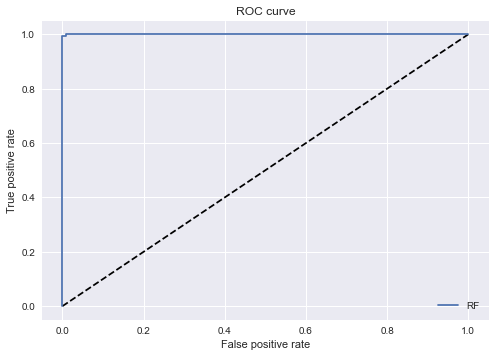

In [109]:
# Performance Metrics
# 2/9測試發現
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

C:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.50      1.00      0.67        46
           1       0.00      0.00      0.00        46

    accuracy                           0.50        92
   macro avg       0.25      0.50      0.33        92
weighted avg       0.25      0.50      0.33        92

Confusion Matrix
[[46  0]
 [46  0]]

Accuracy
0.5


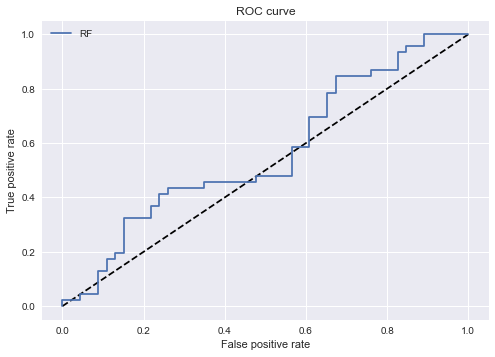

In [110]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_validate)[:, 1]
y_pred = rf.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [111]:
from sklearn.externals import joblib

In [112]:
joblib.dump(rf,'0209_rf.pkl')

['0209_rf.pkl']

In [113]:
# Primary model
# primary_forecast = pd.DataFrame(labels['bin'])
# primary_forecast['pred'] = 1
# primary_forecast.columns = ['actual', 'pred']

# start = primary_forecast.index.get_loc('2016-08-01 10:31:44.455000')
# end = primary_forecast.index.get_loc('2017-12-29 21:03:37.018000') + 1

# subset_prim = primary_forecast[start:end]

# # Performance Metrics
# actual = subset_prim['actual']
# pred = subset_prim['pred']
# print(classification_report(y_true=actual, y_pred=pred))

# print("Confusion Matrix")
# print(confusion_matrix(actual, pred))

# print('')
# print("Accuracy")
# print(accuracy_score(actual, pred))

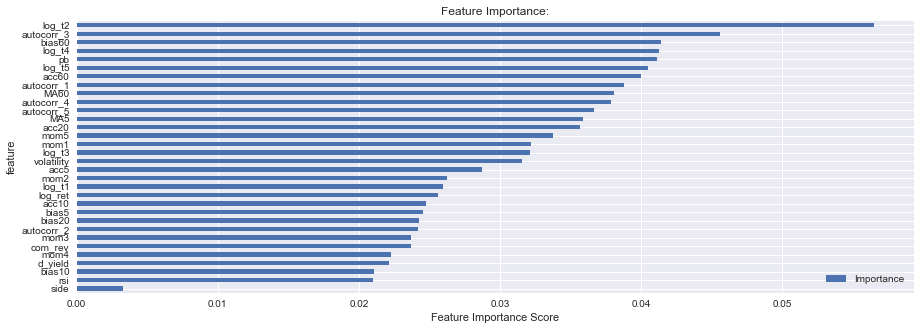

In [114]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

In [115]:
X_training_validation.shape

(458, 32)